<a href="https://colab.research.google.com/github/jimmynewland/colabnotebooks/blob/main/SDSS_BOSS_Plate_Hubbles_Law_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hubble Diagram from Sloan Digital Sky Survey Data



##Question 0
**Double click here to answer. Put your name(s) and class info here.**

Answer: 

<img src="https://www.sdss.org/wp-content/uploads/2014/11/SDSS_telescope_new.jpg" width=500 />

The Sloan Digital Sky Survey (SDSS) has been running at Apache Point Observatory since 2000. This large volume of publicly available data is a perfect place to explore scientific computing and data science while getting a hands on look at Hubble's law.
 
This activity looks at data from the Baryon Oscillation Spectroscopy Survey (BOSS). The specific data here all comes from a spectroscopic plate observation of one chunk of the sky. 

<img src="https://www.sdss.org/wp-content/uploads/2019/11/apogeen-plugging.png" width=500 />

Learn more about the [SDSS Plates](http://voyages.sdss.org/preflight/sdss-plates/)

If you are an educator with a plate that came from the BOSS survey, replace the plate 7045 in the code with the plate number written on your plate. You will need to look through the plate browser to get the modified Julian date or MJD. The MJD system is a way for astronomers to count days in a structured way (it's still strange though). The plate I used was **`7045`**, so according the [plate browser](https://skyserver.sdss.org/dr12/en/tools/getimg/plate.aspx?choosesurvey=boss&P=299489402097264640&S=1868993899549190144&B=7931964954050619392&A=apogee.apo25m.c.r5.4812.55725), the MJD for my plate is **`56577`**

<img src="http://www.jimmynewland.com/wp/wp-content/uploads/2020/08/sdss_7045_plate.png" width=500 />

We are going to explore how Edwin Hubble determined the general relationship between the distance of a galaxy and that galaxy's redshift.

Today you will be using Python running on Google CoLab to analyze data that you will access directly from the SDSS science archive database.

The [orginal version](http://voyages.sdss.org/expeditions/expanding-universe/hubble-diagram/) of this activity uses spreadsheets instead of Python and is also a cool way to explore data from the SDSS plate collection.

## Setup our project

Click on the following block of code to edit and to display the run button.\
***Don't forget to click the run button for each code block, even if you didn't write any code!***\
A handy keyboard shortcut to run and move to the next cell is shift-M.

In [ ]:
# Import data science packages
import seaborn as sns
import pandas as pd
from scipy import stats

# Import NumPy to do mathy stuff
import numpy as np

# Set our project up to plot data
import matplotlib.pyplot as plt
%matplotlib inline
print('Imported modules')

Imported modules


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Install an additional package we need to talk to the SDSS science database
!pip install astroquery

     |████████████████████████████████| 6.5MB 2.4MB/s 
     |████████████████████████████████| 2.6MB 43.5MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=6b8a10b10a8c045fecb19027b2c5d750c74ce704c18c6c0de38d4dc8bd53c579
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


In [ ]:
# Import some astronomy specific packages
from astropy.table import Table
from astroquery.sdss import SDSS
print('Imported modules')

Imported modules


## Supply the plate information

In [ ]:
# Plate browser: https://skyserver.sdss.org/dr12/en/tools/getimg/plate.aspx
# Put your particular plate and MJD here
plate = 7045
mjd = 56577
print('plate =', plate, "\nMJD =", mjd)

plate = 7045 
MJD = 56577


This activity was designed around plates from the [Baryon Oscillation Spectroscopic Survey](https://www.sdss.org/surveys/boss/) or BOSS. Mainly the science targets are galaxies and quasars although the data contains stars which are used as references for the spectroscopy.

We are going to analyze just a small part of the data for all the galaxies on this plate. The BOSS science is not our goal today. Instead, let's explore how this data supports the original idea from Edwin Hubble of universal expansion!

## Query the database

What we are after for our analysis is a list of all the galaxies (not stars and not quasars) including redshift and their brightness (or apparent magnitude).

Here is what we are grabbing from the database
* Object ID
* Right Ascension and Declination
* Apparent Magnitude
* Redshift

### Accessing the data

Here is the Structured Query Language (SQL) query if you want to experiment:
<pre> SELECT TOP 1000 objid, ra, dec, modelMag_i AS app_mag , z
   from SpecPhoto WHERE (class = 'GALAXY' AND plate = '7045')</pre>

This is a database query to retrieve *at most* 1000 objects from this plate. Most plates don't have this many objects but it is a way to limit the results just in case.

The SpecPhoto table from the SDSS database combines together the photometric data (brightness and stuff) and the spectroscopic data ([individual spectra](https://www.sdss.org/dr12/spectro/)). 

<img src="https://www.sdss.org/wp-content/uploads/2014/11/faceplat2.jpg" width=200 />

The brightness data we are using is the [model magnitude](https://www.sdss.org/dr12/algorithms/magnitudes/#mag_model) for the galaxy and is just from one filter, the `i` filter from the [`ugriz`](https://www.sdss.org/instruments/camera/#Filters) filter set. 

<img src="https://skyserver.sdss.org/dr12/en/get/SpecById.ashx?id=7931990242818191360" width=300 />

Note that we rename the model magnitude to `app_mag` to be our apparent magnitude value. The redshift, `z` is the other datapoint we need. Lastly, we limit the class of objects to return. In this case we want only galaxies.

In [ ]:
# Build the query first
query = "SELECT TOP 1000 objid, ra, dec, modelMag_i AS app_mag , z from SpecPhoto WHERE (class = 'GALAXY' AND plate = '7045')"

# Run the query and store the results
result = SDSS.query_sql(query, data_release=16)

## AstroPy and pandas

Let's convert this large chunk of data to something data scientists call a dataframe. We are using the `pandas` data science tool. The `data.head()` line displays the first few rows of the dataframe. It looks a lot like a spreadsheet.

In [ ]:
# Convert our AstroPy data into pandas
data = result.to_pandas()

# Take a look at the first 5 rows
data.head()

,objid,ra,dec,app_mag,z
0,1237679255738253516,18.526920,-3.787903,17.94953,0.260926
1,1237679255201448464,18.648512,-4.169276,19.34472,0.513648
2,1237679323927937131,18.643508,-4.381180,15.88958,0.131451
3,1237679255201448595,18.695452,-4.226731,19.76593,0.517084
4,1237679255201448109,18.643387,-4.140589,18.70874,0.394413


## Plotting the data: app_mag vs z

##Question 1
**Double click here to answer. How does the apparent magnitude of a galaxy act as a way measure distances to galaxies? Must we make any assumptions for the relationship to make sense? (Hint: [what is the inverse square law?](https://openstax.org/books/astronomy/pages/5-1-the-behavior-of-light#OSC_Astro_05_01_Invlight))**

Answer:

## Question 2
**Double click here to answer. Which of our data variables, app_mag or z, makes the most sense as the independent variable? One variable came from a camera (the magnitude). The other came from measuring the shift in the spectrum.**

Answer:

### Independent vs dependent
First lets just plot the data and see what we get. Typically we plot the dependent variable along the y-axis and the independent variable along the x-axis. 

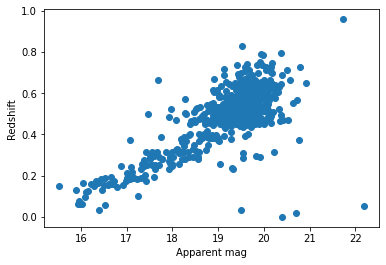

In [ ]:
# Perform a scatter plot

# What should we put along the x and y axes?
# Choose the data axes like this (except use real column names): 
# x = data['ColForX'] and y = data['ColForY']
x = data['app_mag']
y = data['z']

# The plt object plots our data. 
# Here we want a scatter plot.
# Whatever list you put 1st is x, and the 2nd is y.
plt.scatter(x,y)

# Change these to something useful
plt.xlabel('Apparent mag')
plt.ylabel('Redshift')

# Display our plot.
plt.show()

##Question 3
**Double click here to answer. What do you notice and what do you wonder about our plot? Is there a linear relationship between x and y? Is there more than one group here? Can you identify any outliers?**

Answer:


### Redshift as speed

Edwin Hubble showed the earlier ideas about the universe expanding were true. He discovered that the amount of redshift of a galaxy seemed to depend on the distance that galaxy is from us. We are going to explore this exact relationship with our data.

<img src="https://openstax.org/resources/7f27f064e23d86aa9968b4ef8642cbe37194697e" width=75% />

[Check out more about Hubble and Humason](https://openstax.org/books/astronomy/pages/26-5-the-expanding-universe#OSC_Astro_26_05_HLaw)

##Question 4
**Double click here to answer. In your own words, what does redshift mean for a galaxy? How is the measured redshift related to 'speed'? (Hint: [what is Hubble's law?](https://openstax.org/books/astronomy/pages/26-5-the-expanding-universe#OSC_Astro_26_05_HLaw))**

Answer:

## Linear Regression: app_mag vs z

Next let's plot the data but let's use a linear regression tool to see if the 2 variables have a linear relationship. Use the same columns for x and y you used before. A linear regression is a way to test how closely one variable varies with respect to another.

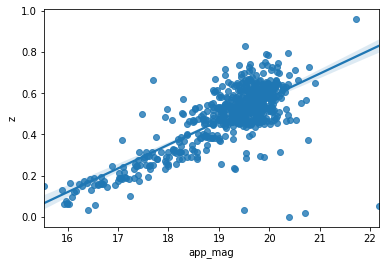

In [ ]:
# What should we put along the x and y axes?
x = data['app_mag']
y = data['z']

# Run the linear regression on our data and plot it.
sns.regplot(x,y)

# Note that the regplot function chooses the axes names for you

plt.show()

##Question 5
**Double click here to answer. What do you notice and what do you wonder about our NEW plot? Is there a linear relationship between x and y? Is there more than one population here? Can you identify any outliers? What is the significance of the lighter colored area around the line?**

Answer:


## Magnitude, Luminosity, and Flux

The data we have is the [apparent magnitude](https://openstax.org/books/astronomy/pages/17-1-the-brightness-of-stars) for our galaxies. We need to convert our apparent magnitude into a flux value. The relationship between [magnitude and flux is exponential](https://openstax.org/books/astronomy/pages/17-1-the-brightness-of-stars#OSC_Astro_17_01_Apparent). Hipparchus in 150 BCE didn't know about that relationship when he created the magnitude scale. Since we still use the old magnitude scale but now we know how the system works, we can convert from magnitude to flux using:

$$F = 2.5^{-m}$$

Where `m` is our apparent magnitude data, and `F` is the flux. And we know from the inverse square law that flux (or luminosity) is proportional the inverse square of distance.

$$F \propto {1 \over d^2}$$

So if solve for d we get:

$$d\propto {1 \over \sqrt{F}} $$

##Convert apparent magnitude to flux
**Python HOWTO - exponents:** the equation $y=x^{-2}$  would be `y = x**-2` in Python.

In [ ]:
# Set m equal to the apparent magnitude.
m = 0

# Raise 2.5 to the -m power
flux = 0 

**Python HOWTO - square roots:** the equation $y=\sqrt{x}$ would be `y = np.sqrt(x)`

In [ ]:
# Use the inverse square relationship to get relative distance.

# np.sqrt finds the square root of number
rel_dist = 0

**Python HOWTO - find the max:** to find the max value in a list of items, do this: `largest = my_list.max()`

In [ ]:
# Let's 'normalize' our relative distances. 
# Based on our farthest galaxy, what's the relative dist. to the others?
farthest = 0

# Divide our list of relative distances by our farthest distance
rel_dist = 0

In [ ]:
# Add in the relative distance to our data cube.
data = data.assign(rel_dist=rel_dist)

### Plot app_mag vs z and rel_dist vs z

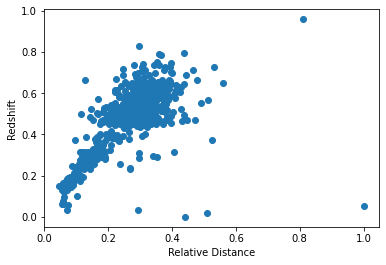

In [ ]:
# Following the examples above, display a scatter plot rel_dist vs z

x = 0
y = 0

# Plot here

# Change these to something useful
plt.xlabel('Change me')
plt.ylabel('Me too')

# Display our plot.
# Show here

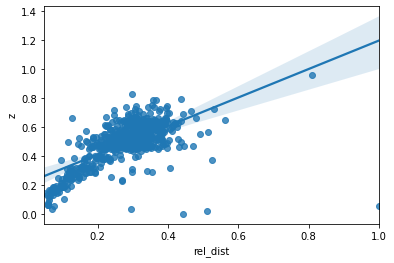

In [ ]:
# Following the examples above, plot a linear regression
# of rel_dist and z
x = 0
y = 0

sns.regplot(x,y)

plt.show()

## Histogram of distances

**Python HOWTO:** Make a histogram with MatPlotLib. 'plt.hist(values, bins)`

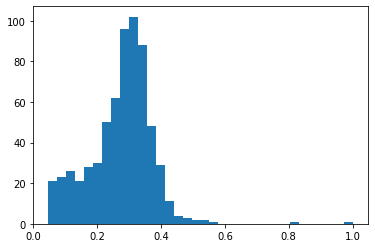

In [ ]:
# Make the x variable our distribution of relative distances
x = 0

# Plot a histogram with equally spaced bins
bins = 34     # try different numbers of bins
plt.hist(x, bins)

plt.show()

## Question 6
**Double click here to answer. What does the histogram say about the variation in the relative distances? Are most galaxies close or far? What does the skew direction say about our population of galaxies?**

Answer: 

## Eliminate outliers

If we think that the data we have should follow a bell curve then data way off the curve can skew our results. There might be some reason for the relationship breaking down for some galaxies besides our claim being wrong.

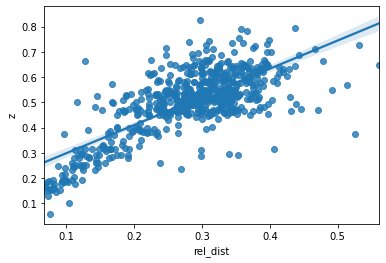

In [ ]:
# Remove outliers and make a new dataframe
newdata = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

# Technically we removed all data not following a Gaussian distribution beyond
# 4 standard deviations from the mean of the data.

# Plot the linear regression of the new dataframe
x = 0
y = 0
sns.regplot(x,y)


plt.show()

##Question 7
**Double click here to answer. Now that some of the outliers have been removed and we again plot the linear regression of our data, what do you notice and what do you wonder? Why might some of the galaxies that are outliers not follow the relationship of apparent brightness to distance or recession speed? Should we eliminate the outliers here or leave them in? Justify your answer.**

Answer:


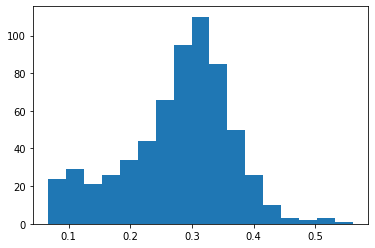

In [ ]:
x = newdata['rel_dist']

plt.hist(x,17)
plt.show()

## Question 8
**Double click here to answer. How does the 2nd histogram support or not support our decision to remove the outliers? Does the distribution now follow the Gaussian bell curve? What does this distribution of galaxies say about our dataset with the outliers removed?**

Answer: 

# Sky Chart - Plot the galaxies in the sky

Produce a scatter plot with the x-axis set to the right ascension values and the y-axis set to the declination values. This is where in the field of view of the telscope these galaxies were located.

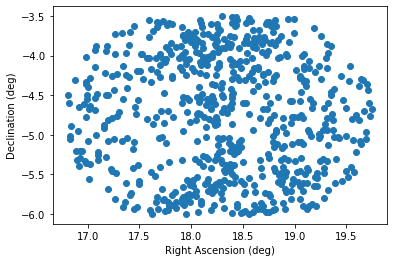

In [ ]:
x = 0
y = 0

plt.scatter(x,y)

plt.xlabel('Good choice for name here')
plt.ylabel('Same here')

plt.show()

## Sky Chart with size and color
Here we plot the galaxies with the color and size of the dot based on the relative distance we calculated. This is a clever bit of data visualization that helps bring a sort of 3rd dimension to our data.

We want the closest galaxies to appear larger and darker as farther galaxies shrink and fade out. use `x.max()` and `x.min()` to check the largest and smallest values for `newdata['rel_dist']`

In [ ]:
print(newdata['rel_dist'].max(), newdata['rel_dist'].min())

0.5605358440348641 0.06716999080406347


Invert the "sense" of the data so the nearest galaxies have the largest index and the farthest have the smallest.

In [ ]:
inv_dist = 1-newdata['rel_dist']

Check the new largest and smallest values with `x.max()` and `x.min()`

In [ ]:
print(inv_dist.max(), inv_dist.min())

0.9328300091959365 0.4394641559651359


Now plot ra vs. dec and show relative distances with size and color (hue).

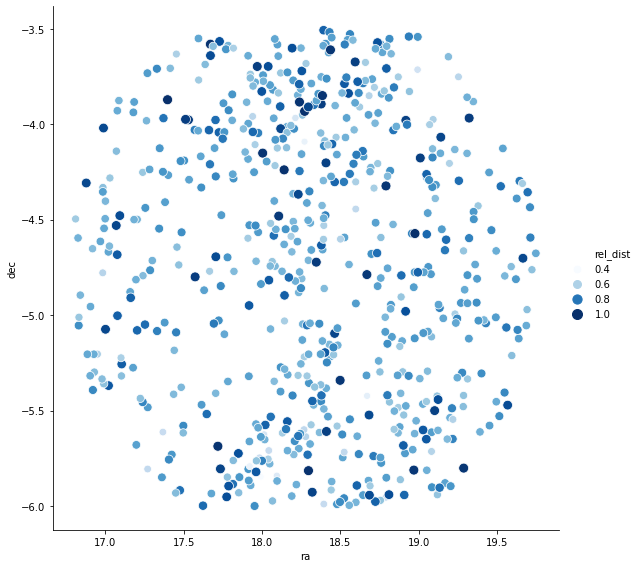

In [ ]:
sns.relplot(x='ra', y='dec', hue=inv_dist, size=inv_dist, palette='Blues', 
            data=newdata, height=8, sizes=(45,100))

plt.show()

## Question 9
**Double click here to answer. Using the new sky chart, can any pattern for the distribution of close and far galaxies be seen in the sky?**

Answer: 